In [ ]:
#system("source activate sf_test")

In [ ]:
#install.packages('ggplot2')
#install.packages("dplyr")

In [1]:
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#find the .BED files of Roadmap enhancers intersected with hg38 files containing species counts
path <- "/dors/capra_lab/users/fongsl/broadly_active_enhancers/data/roadmap_multi_data/hg38/human_specific"
setwd(path)

In [9]:
a <- list.files(pattern = "\\.bed$")

In [10]:
print(a)

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 


In [45]:
bedfile = a[10]
print(bedfile)
df <-read.table(bedfile, sep = '\t', h=F, stringsAsFactors=F)
dim(df)
head(df)

[1] "chr18_hspec_x_hg38.bed"


[1] 727839     14

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
chr18,9960,10014,1,0.10,.,-1,-1,.,.,.,.,.,0
chr18,10014,10264,2,0.26,chr18,10148,10750,+,hg38,1,0,[ornAna1],116
chr18,10264,10286,1,0.10,chr18,10148,10750,+,hg38,1,0,[ornAna1],22
chr18,63671,63859,1,0.10,chr18,62890,63829,+,hg38,0,0,[],158
chr18,63671,63859,1,0.10,chr18,63828,63873,+,hg38,1,0,[papAnu2],31
chr18,71042,71266,1,0.10,chr18,70953,71233,+,hg38,5,0,"[panTro4, ponAbe2, nomLeu3, macFas5, chlSab2]",191


In [58]:
headers <- c("enh_chr", "enh_start", "enh_end", "enh_overlap", "enh_percentile", "hg38_chr", "hg38_start", "hg38_end", "hg38_strand", "hg38_ref", "hg38_100spec", "hg38_8vspec", "hg38-100spec_names", "length")

# create empty dataframes to specifically collect information about human-specific enhancers in hg38 alignments

hspecific <- data.frame(matrix(ncol = length(headers), nrow = 0))
colnames(hspecific) <- headers

# create empty dataframe to specifically collect information about broadly active enhancers and conservation

bae <- data.frame(matrix(ncol = length(headers), nrow = 0))
colnames(bae) <- headers
 
head(bae)

enh_chr,enh_start,enh_end,enh_overlap,enh_percentile,hg38_chr,hg38_start,hg38_end,hg38_strand,hg38_ref,hg38_100spec,hg38_8vspec,hg38-100spec_names,length


In [57]:
graph_stuff <-function(bedfile){
    # make dataframe of the bedfile
    df <-read.table(bedfile, sep = '\t', h=F, stringsAsFactors=F)
    
    chr= unlist(strsplit(bedfile, "_"))[1]
    print(chr)
    ## format the table

    # rename columns
    names(df) = c("enh_chr", "enh_start", "enh_end", "enh_overlap", "enh_percentile", "hg38_chr", "hg38_start", "hg38_end", "hg38_strand", "hg38_ref", "hg38_100spec", "hg38_8vspec", "hg38-100spec_names", "length")

    # convert species count columns from characters to integers 
    df$hg38_100spec <- as.integer(df$hg38_100spec)
    df$hg38_8vspec <- as.integer(df$hg38_8vspec)

    # calculate the length of fragment overlap in log10
    df$log10_length = log(df$length, 10)
    
    # create a subset of the dataframe to remove non-overlapping roadmap fragments in hg38 MSA
    df2 = subset(df, df$length >0)

    #make a subset of the counts
    df_count <-plyr::count(df2, vars = c( "hg38_100spec","enh_overlap"))
    
    #make a heatmap
    ggplot(df_count, aes(y = enh_overlap, x =hg38_100spec)) + 
        geom_tile(aes(fill = freq), color = "white")+
        scale_fill_gradient(low = "steelblue",high = "white")+
        ggtitle(paste0("Hg38 Species Alignments x Roadmap Enhancer Sample-Overlap - ", chr))
    ggsave(paste0(chr,"_hg38_heatmap.pdf"), path = paste0(path,"/result_pdf/"), device = "pdf", width = 7, height = 5, units = "in", dpi=300)
    
    #make a histogram of the species conservation x the number of peaks that overlap each species-count.
    ggplot(df2, aes(hg38_100spec)) + 
        geom_histogram(bins = 100) +
        ggtitle(paste0("overlap of Hg38 species in roadmap enhancers (multi-intersected) - ", chr)) 
    ggsave(paste0(chr,"_hg38_histogram.pdf"), path = paste0(path,"/result_pdf/"), device = "pdf", width = 7, height = 5, units = "in", dpi=300)
    
    # relatedness of species/ misrepresentation of species diversity in dataset might skew our interpretation of this graph 
    
    ggplot(df2, aes(x = hg38_100spec, y = enh_overlap, color=log10_length)) + 
        geom_point() +
        scale_fill_gradient(low = "steelblue", high = "white")
    ggsave(paste0(chr,"_hg38_dot.pdf"), path = paste0(path,"/result_pdf/"), device = "pdf", width = 8, height = 8, units = "in", dpi=300)

    #while we're here, let's collect information on human-specific and broadly active enhancers across hg38.
    chr_hspec = subset(df2, df2$hg38_100spec ==0)
    hspecific =rbind(hspecific, chr_hspec)

    chr_bae = subset(df2, df2$enh_percentile>0.9)
    bae = rbind(bae, chr_bae)

}

In [59]:
for (bedfile in a){
        graph_stuff(bedfile)
    }

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr1"


Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr10"
 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed

Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr13"


Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr14"


Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr15"
 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed

Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr19"


Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr2"
 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"

Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr21"


Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr22"
 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed

Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr4"


Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"
[16] "chr3_hspec_x_hg38.bed"  "chr4_hspec_x_hg38.bed"  "chr5_hspec_x_hg38.bed" 
[19] "chr6_hspec_x_hg38.bed"  "chr7_hspec_x_hg38.bed"  "chr8_hspec_x_hg38.bed" 
[22] "chr9_hspec_x_hg38.bed" 
[1] "chr5"
 [1] "chr1_hspec_x_hg38.bed"  "chr10_hspec_x_hg38.bed" "chr11_hspec_x_hg38.bed"
 [4] "chr12_hspec_x_hg38.bed" "chr13_hspec_x_hg38.bed" "chr14_hspec_x_hg38.bed"
 [7] "chr15_hspec_x_hg38.bed" "chr16_hspec_x_hg38.bed" "chr17_hspec_x_hg38.bed"
[10] "chr18_hspec_x_hg38.bed" "chr19_hspec_x_hg38.bed" "chr2_hspec_x_hg38.bed" 
[13] "chr20_hspec_x_hg38.bed" "chr21_hspec_x_hg38.bed" "chr22_hspec_x_hg38.bed"

Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”Warning message in graph_stuff(bedfile):
“NAs introduced by coercion”

In [ ]:
###THE NEXT PART OF THIS SCRIPT BREAKS DOWN THE GRAPH_STUFF FUNCTION INTO PIECES FOR FURTHER DEVELOPMENT###

In [ ]:
# format the table

# rename columns
names(df) = c("enh_chr", "enh_start", "enh_end", "enh_overlap", "enh_percentile", "hg38_chr", "hg38_start", "hg38_end", "hg38_strand", "hg38_ref", "hg38_100spec", "hg38_8vspec", "hg38-100spec_names", "length")

# convert species count columns from characters to integers 
df$hg38_100spec <- as.integer(df$hg38_100spec)
df$hg38_8vspec <- as.integer(df$hg38_8vspec)
df$enh_percentile <- as.numeric(df$enh_percentile)

# calculate the length of fragment overlap in log10
df$log10_length = log(df$length, 10)

# create a subset of the dataframe to remove non-overlapping roadmap fragments in hg38 MSA
df2 = subset(df, df$length >0)

#make a subset of the counts
df_count <-plyr::count(df2, vars = c( "hg38_100spec","enh_overlap"))

head(df2)

In [70]:
df_count <-plyr::count(bae, vars = c( "hg38_100spec","enh_overlap"))
head(df_count)

hg38_100spec,enh_overlap,freq
0,17,19
0,18,9
0,19,8
0,20,3
0,21,2
0,22,1


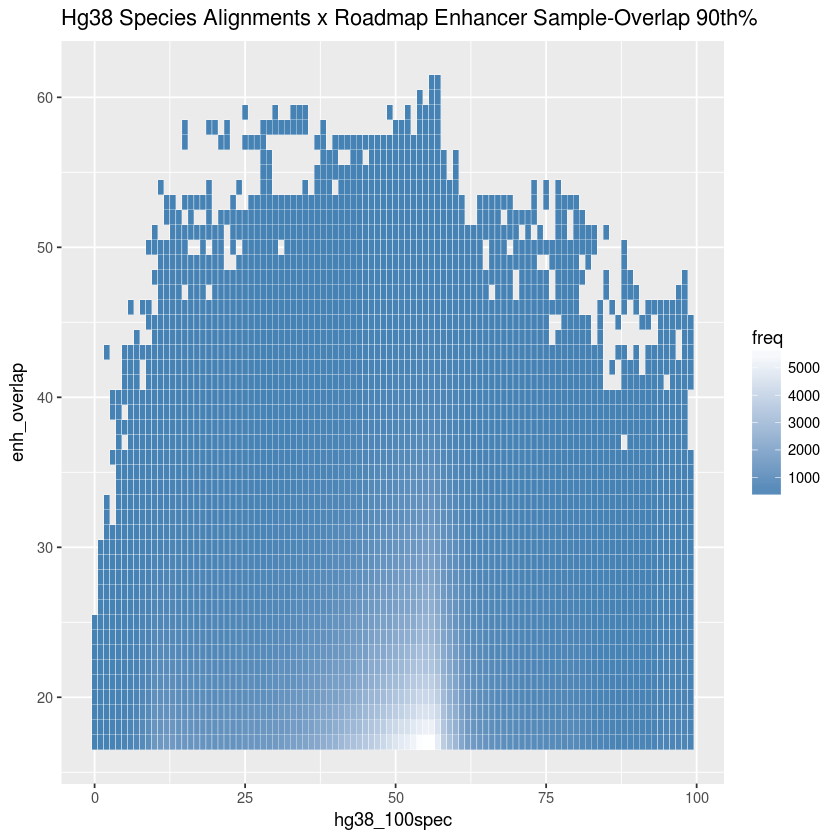

In [77]:
# the frequency of species-specific enhancers x the number of samples enhancers are found in
ggplot(df_count, aes(y = enh_overlap, x =hg38_100spec)) + 
geom_tile(aes(fill = freq), color = "white")+
scale_fill_gradient(low = "steelblue",high = "white")+
ggtitle("Hg38 Species Alignments x Roadmap Enhancer Sample-Overlap 90th%")

ggsave("Hg38spec_X_roadmap90th_heatmap.pdf", path = paste0(path,"/result_pdf/"), device = "pdf", width = 6, height = 4, units = "in", dpi=300)

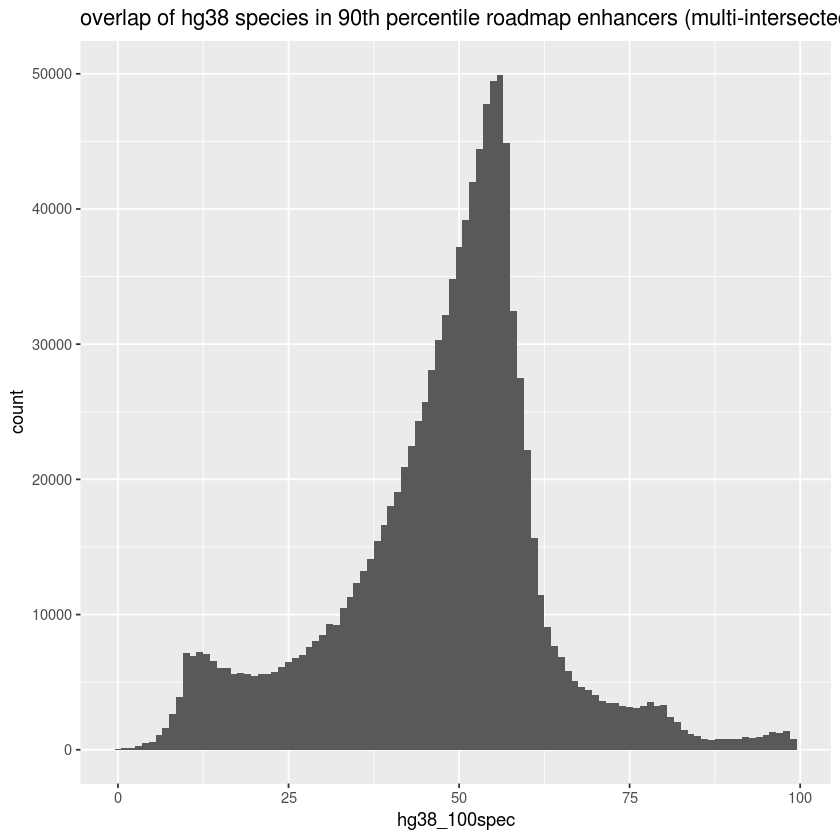

In [78]:
ggplot(bae, aes(hg38_100spec)) + 
geom_histogram(bins = 100) +
ggtitle("overlap of hg38 species in 90th percentile roadmap enhancers (multi-intersected)") 
ggsave("Hg38spec_X_roadmap90th_histogram.pdf", path = paste0(path,"/result_pdf/"), device = "pdf", width = 4, height = 4, units = "in", dpi=300)
# relatedness of species/ misrepresentation of species diversity in dataset might skew our interpretation of this graph 

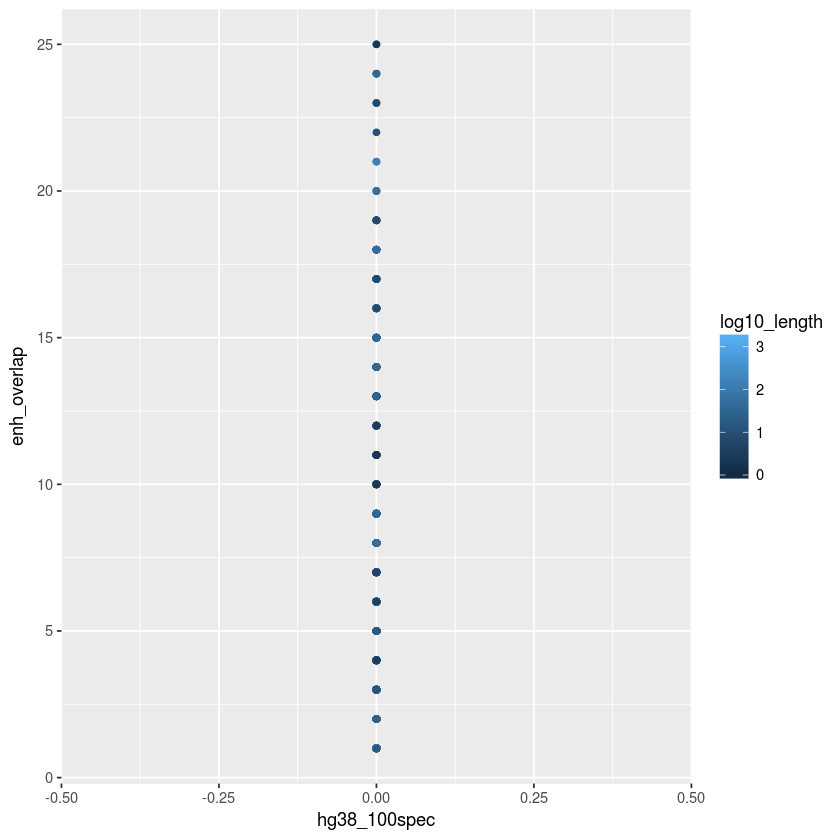

In [73]:
ggplot(hspecific, aes(x = hg38_100spec, y = enh_overlap, color=log10_length)) + 
geom_point() +
scale_fill_gradient(low = "steelblue", high = "white")+
ggsave("chr18_dot.pdf", path = paste0(path,"/result_pdf/"), device = "pdf", width = 4, height = 4, units = "in", dpi=300)

In [54]:
# how many Roadmap enhancers do not overlap any sequencing block in Multiz100-way?

noverlap = subset(df, df$length==0)
length(noverlap)

chr_hspec = subset(df2, df2$hg38_100spec ==0)
hspecific =rbind(hspecific, chr_hspec)

chr_bae = subset(df2, df2$enh_percentile>0.9)
bae = rbind(bae, chr_bae)


[1] 15

In [64]:
for (bedfile in a){
    print(bedfile)
    # make dataframe of the bedfile
    df <-read.table(bedfile, sep = '\t', h=F, stringsAsFactors=F)
    
    chr= unlist(strsplit(bedfile, "_"))[1]
    print(chr)
    ## format the table

    # rename columns
    names(df) = c("enh_chr", "enh_start", "enh_end", "enh_overlap", "enh_percentile", "hg38_chr", "hg38_start", "hg38_end", "hg38_strand", "hg38_ref", "hg38_100spec", "hg38_8vspec", "hg38-100spec_names", "length")

    # convert species count columns from characters to integers 
    df$hg38_100spec <- as.integer(df$hg38_100spec)
    df$hg38_8vspec <- as.integer(df$hg38_8vspec)

    # calculate the length of fragment overlap in log10
    df$log10_length = log(df$length, 10)
    
    # create a subset of the dataframe to remove non-overlapping roadmap fragments in hg38 MSA
    df2 = subset(df, df$length >0)

    chr_hspec = subset(df2, df2$hg38_100spec ==0)
    hspecific =rbind(hspecific, chr_hspec)

    chr_bae = subset(df2, df2$enh_percentile>0.9)
    bae = rbind(bae, chr_bae)
}

[1] "chr1_hspec_x_hg38.bed"
[1] "chr1"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

[1] "chr10_hspec_x_hg38.bed"
[1] "chr10"
[1] "chr11_hspec_x_hg38.bed"
[1] "chr11"
[1] "chr12_hspec_x_hg38.bed"
[1] "chr12"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

[1] "chr13_hspec_x_hg38.bed"
[1] "chr13"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

[1] "chr14_hspec_x_hg38.bed"
[1] "chr14"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

[1] "chr15_hspec_x_hg38.bed"
[1] "chr15"
[1] "chr16_hspec_x_hg38.bed"
[1] "chr16"
[1] "chr17_hspec_x_hg38.bed"
[1] "chr17"
[1] "chr18_hspec_x_hg38.bed"
[1] "chr18"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

[1] "chr19_hspec_x_hg38.bed"
[1] "chr19"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

[1] "chr2_hspec_x_hg38.bed"
[1] "chr2"
[1] "chr20_hspec_x_hg38.bed"
[1] "chr20"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

[1] "chr21_hspec_x_hg38.bed"
[1] "chr21"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

[1] "chr22_hspec_x_hg38.bed"
[1] "chr22"
[1] "chr3_hspec_x_hg38.bed"
[1] "chr3"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

[1] "chr4_hspec_x_hg38.bed"
[1] "chr4"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

[1] "chr5_hspec_x_hg38.bed"
[1] "chr5"
[1] "chr6_hspec_x_hg38.bed"
[1] "chr6"
[1] "chr7_hspec_x_hg38.bed"
[1] "chr7"
[1] "chr8_hspec_x_hg38.bed"
[1] "chr8"
[1] "chr9_hspec_x_hg38.bed"
[1] "chr9"


Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

In [84]:
b_out<-summary(bae)
write.table(b_out,file = paste0(path,"/bae_summary_hg38spec_x_roadmap.txt"),append = FALSE, quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE) 
h_out <- summary(hspecific)
write.table(h_out,file = paste0(path,"/hspecific_summary_hg38spec_x_roadmap.txt"),append = FALSE, quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE) 

In [75]:
write.table(bae, file = paste0(path,"/hg38_90th_percentile_x_100species.bed"), append = FALSE, quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
write.table(hspecific, file = paste0(path,"/hg38_human_specific_x_100species.bed"), append = FALSE, quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)



In [37]:
lapply(df2, class)
str(df2)

$enh_chr
[1] "character"

$enh_start
[1] "integer"

$enh_end
[1] "integer"

$enh_overlap
[1] "integer"

$enh_percentile
[1] "numeric"

$hg38_chr
[1] "character"

$hg38_start
[1] "integer"

$hg38_end
[1] "integer"

$hg38_strand
[1] "character"

$hg38_ref
[1] "character"

$hg38_100spec
[1] "integer"

$hg38_8vspec
[1] "integer"

$`hg38-100spec_names`
[1] "character"

$length
[1] "integer"

$log10_length
[1] "numeric"

'data.frame':	727829 obs. of  15 variables:
 $ enh_chr           : chr  "chr18" "chr18" "chr18" "chr18" ...
 $ enh_start         : int  10014 10264 63671 63671 71042 71042 110750 111347 111438 111467 ...
 $ enh_end           : int  10264 10286 63859 63859 71266 71266 111293 111438 111467 111513 ...
 $ enh_overlap       : int  2 1 1 1 1 1 1 1 2 3 ...
 $ enh_percentile    : num  0.26 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.26 0.39 ...
 $ hg38_chr          : chr  "chr18" "chr18" "chr18" "chr18" ...
 $ hg38_start        : int  10148 10148 62890 63828 70953 71232 105475 105475 105475 105475 ...
 $ hg38_end          : int  10750 10750 63829 63873 71233 71378 111831 111831 111831 111831 ...
 $ hg38_strand       : chr  "+" "+" "+" "+" ...
 $ hg38_ref          : chr  "hg38" "hg38" "hg38" "hg38" ...
 $ hg38_100spec      : int  1 1 0 1 5 6 0 0 0 0 ...
 $ hg38_8vspec       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hg38-100spec_names: chr  "[ornAna1]" "[ornAna1]" "[]" "[papAnu2]" ...
 $ length            : int  116 